In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from validation_helpers import *
from plots import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [5]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [7]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [8]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)

cleaned_with_median_with_momentum = add_momentum_vector(cleaned_with_median)

In [9]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '../data/test.csv' 
y_donotUse, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [13]:
#separate data with respect to column 24 and remove None
split_x_test, _, split_ids_test =  separate(y_donotUse, tX_test, ids_test)


split_x_cleaned_test = removeNone(split_x_test, dataStatistics(split_x_test))

#median instead of None
split_x_with_median = putMedianInsteadOfNone(split_x_cleaned_test)

split_x_with_median_with_momentum = add_momentum_vector(split_x_with_median)

#line dropped when None
#split_x_drop_lines, split_y_dropped_split_indexes_dropped = dropLineIfNone(split_x_cleaned_test, _, split_ids_test)

#degrees for polynomial feature expension
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

y_res = []

acc = []

plot_data_per_jetnum = []


for i in range(len(cleaned_with_median)):
    
    
    
    #training: chose either cross calidation or cross validation for logistic regression with regularization
    w_star, d, accuracy, training_set, plot_data = crossValidation_with_loss(cleaned_with_median[i], split_y[i], 0.90, degrees ,6)
    #w_star, d, accuracy, training_set, plot_data = crossValidationForLogistic_reg_with_loss(cleaned_with_median[i], split_y[i], 0.9, degrees ,6)
    
    
    #polynomial feature expension and normalization using the training data
    mean = np.mean(build_poly(training_set,d), axis = 0)
    std = np.std(build_poly(training_set,d), axis = 0)
    
      
    #put 1 if std = 0
    std = std + (std == 0)
    
    extended_and_normalized = (build_poly(split_x_with_median[i], d) - mean) / std
    
    #adding bias term
    bias = np.ones(shape=split_x_with_median[i].shape)          
    x_test_ready = np.c_[bias, extended_and_normalized]
    
    #prediction for least squares
    #y_res.append(predict_labels(w_star, x_test_ready))
    
    #prediction for logistic
    y_res.append(predict_labels_logistic(w_star, x_test_ready))
    


    acc.append(accuracy)
    plot_data_per_jetnum.append(plot_data)

print("Accuracy per jet nbr: \n")
print(acc)


Statistics 
Type :
0
[0.2605448 0.        0.        0.        1.        1.        1.
 0.        0.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        1.        1.        1.        1.
 1.        0.       ]
Statistics 
Type :
1
[0.09834149 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05881481 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.06376737 0.         0.     

lambda=0.10000,degree=15, Training Loss=1105039.8643780542, Testing Loss=118527.66322520445
lambda=0.10000,degree=16, Training Loss=1039303.1092608181, Testing Loss=114169.36165595826
lambda=0.20000,degree=1, Training Loss=859912.7167739731, Testing Loss=93116.54995625203
lambda=0.20000,degree=2, Training Loss=671757.2321654599, Testing Loss=74832.45432204509
lambda=0.20000,degree=3, Training Loss=1105284.67412684, Testing Loss=121952.49609600492
lambda=0.20000,degree=4, Training Loss=808874.8532681335, Testing Loss=88107.7856681012
lambda=0.20000,degree=5, Training Loss=1040664.7392698118, Testing Loss=115309.0760618972
lambda=0.20000,degree=6, Training Loss=844707.6594275883, Testing Loss=91955.22443904163
lambda=0.20000,degree=7, Training Loss=905315.4050965246, Testing Loss=100477.69424908582
lambda=0.20000,degree=8, Training Loss=741157.4027965771, Testing Loss=81566.72545574256
lambda=0.20000,degree=9, Training Loss=788656.7708304164, Testing Loss=85667.44721374263
lambda=0.20000

lambda=0.10000,degree=11, Training Loss=210274.661854853, Testing Loss=22241.46169665617
lambda=0.10000,degree=12, Training Loss=373426.30829366995, Testing Loss=41533.400758497824
lambda=0.10000,degree=13, Training Loss=211782.55173765577, Testing Loss=21827.13778975687
lambda=0.10000,degree=14, Training Loss=236250.8423577968, Testing Loss=27949.956770642733
lambda=0.10000,degree=15, Training Loss=350701.05828843656, Testing Loss=39321.3019950363
lambda=0.10000,degree=16, Training Loss=244051.97960379365, Testing Loss=26288.08559222489
lambda=0.20000,degree=1, Training Loss=225040.60395651092, Testing Loss=21931.856389235814
lambda=0.20000,degree=2, Training Loss=208000.23464738467, Testing Loss=21782.13580664066
lambda=0.20000,degree=3, Training Loss=373271.82364480384, Testing Loss=41553.87603162925
lambda=0.20000,degree=4, Training Loss=207536.02847128603, Testing Loss=22065.935607352505
lambda=0.20000,degree=5, Training Loss=250015.95843705, Testing Loss=26916.909805037154
lambda

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

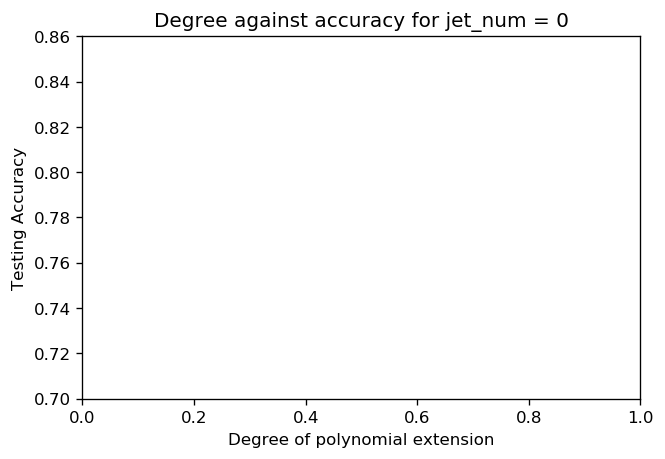

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i in range(len(plot_data_per_jetnum)):
    jet_num = plot_data_per_jetnum[i]



    X = np.array([x[0] for x in jet_num])
    Y = np.array([x[1] for x in jet_num])
    Z = np.array([x[3] for x in jet_num])
    

    plt.figure(dpi=120)
    plt.title('Degree against accuracy for jet_num = %d' %i)
    plt.xlabel('Degree of polynomial extension')
    plt.ylabel('Testing Accuracy')

    axes = plt.gca()
    axes.set_ylim([0.7,0.86])

    plt.stem(Y, Z, use_line_collection=True, label="hello")
    plt.savefig("cross_with_momentum_"+str(i))
    plt.show()


In [14]:
OUTPUT_PATH = '../data/submission.csv'
#reassemble the data for the submission
y_pred = put_together(y_res, split_ids_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)